<a href="https://colab.research.google.com/github/JOHNPAUL-ADIMS/Research-Topic-Modelling-with-LDA/blob/main/Transportation_Research_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

**Task Title** -- Identification of top 25 research topics for Transportation Research Part B between 2010 and 2017

**Methodology**

The methodology used in this analysis include the following:

1. Collected and extracted of data from the TRID website: (https://trid.trb.org/). This was done based on the following criteria:
      *   Date range - (2010 - 2017)
      *   Selection of all papers under *Transportation Research Part B* serials / conferences
      *   Language of publication selected was English
      *   Saving the file to ris format

2. Loading the data on google colab, and reading the file with python
3. Cleaning, wrangling and performimg of analysis to understand number of publications was carried out in a year
4. Developed the Latent Dirichlet Allocation (LDA) topic model
5. Identified the top 25 research topics and visualized it using WordCloud and PyDavis
6. Computed Model Perplexity and Coherence Score to judge how good our model is.
6. Insights and Summary from the Topics.









**Task Scope**

The scope covered in this task:
1. Identifying the Top 25 topics of Transportation Research Part B between 2010 and 2017
2. The analysis done in this task does not include the top topic trend with time.
3. The analysis done does not include geographical locations.


# **Installation of important packages**


Downloading NLTK and Spacy for test modelling

In [1]:
!pip install tqdm 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import spacy



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Importing of necessary packages that will help in this project

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime

#Importing of Genism --Gensim is a free open-source Python library used to represent documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible.
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Importing some plotting tools to aid in visualisation
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1541e5a30a8d5469206126e45b3891395dbdf6fe9a1ed12d5d2ff804edab7315
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
# Importing the google colab table format

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [4]:
from nltk.corpus import stopwords

In [5]:
print(stopwords)

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>


# **Importing and Loading of the Data**

In [6]:
!pip install RISparser

In [7]:
!git clone https://github.com/JOHNPAUL-ADIMS/Research-Topic-Modelling-with-LDA.git

Cloning into 'Research-Topic-Modelling-with-LDA'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [8]:

from RISparser import readris
from RISparser.config import TAG_KEY_MAPPING

#Reading my ris file
filepath = '/content/Research-Topic-Modelling-with-LDA/TRIDRIS_2022-02-26.ris'

mapping = TAG_KEY_MAPPING
mapping["SP"] = "pages_this_is_my_fun"
with open(filepath, 'r') as bibliography_file:
  entries = list(readris(bibliography_file, mapping=mapping))

  # converting the dictionary to a dataframe
  df = pd.DataFrame.from_dict(entries)
  data_table.disable_dataframe_formatter()
  #checking out for the top rows
  display(df.head())

 


,type_of_reference,accession_number,journal_name,publisher,authors,title,year,volume,pages_this_is_my_fun,abstract,keywords,type_of_work,doi,url,number
0,JOUR,01655669,Transportation Research Part B: Methodological,Elsevier,"[Ng, Ka Fai, Lo, Hong K]",On joint railway and housing development: Hous...,2017/12,106,pp 464-488,This paper develops a time-dependent framework...,"[Housing, Logits, Programming (Mathematics), R...",Web,https://doi.org/10.1016/j.trb.2017.06.003,https://www.sciencedirect.com/science/article/...,NaN
1,JOUR,01655668,Transportation Research Part B: Methodological,Elsevier,"[Urena Serulle, Nayel, Cirillo, Cinzia]",The optimal time to evacuate: A behavioral dyn...,2017/12,106,pp 447-463,Understanding what affects the decision proces...,"[Disaster preparedness, Dynamic models, Evacua...",Web,https://doi.org/10.1016/j.trb.2017.06.004,https://www.sciencedirect.com/science/article/...,NaN
2,JOUR,01655667,Transportation Research Part B: Methodological,Elsevier,"[Wang, Xiubin Bruce, Cao, Xiaowei, Wang, Chang...",Dynamic optimal real-time algorithm for signal...,2017/12,106,pp 433-446,This paper studies intersection signal control...,"[Algorithms, Delays, Green interval (Traffic s...",Web,https://doi.org/10.1016/j.trb.2017.06.005,https://www.sciencedirect.com/science/article/...,NaN
3,JOUR,01655666,Transportation Research Part B: Methodological,Elsevier,"[Hu, Xiao-Bing, Zhang, Ming-Kong, Zhang, Qi, L...",Co-Evolutionary path optimization by Ripple-Sp...,2017/12,106,pp 411-432,Static path optimization (SPO) is a foundation...,"[Agent based models, Genetic algorithms, Intel...",Web,https://doi.org/10.1016/j.trb.2017.06.007,https://www.sciencedirect.com/science/article/...,NaN
4,JOUR,01655665,Transportation Research Part B: Methodological,Elsevier,"[Zetina, Carlos Armando, Contreras, Ivan, Cord...",Robust uncapacitated hub location,2017/12,106,pp 393-410,In this paper the authors present robust count...,"[Costs, Demand, Hubs, Location, Mixed integer ...",Web,https://doi.org/10.1016/j.trb.2017.06.008,https://www.sciencedirect.com/science/article/...,NaN


# **Data Wrangling and Cleaning**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   type_of_reference     1078 non-null   object
 1   accession_number      1078 non-null   object
 2   journal_name          1078 non-null   object
 3   publisher             1078 non-null   object
 4   authors               1078 non-null   object
 5   title                 1078 non-null   object
 6   year                  1078 non-null   object
 7   volume                1078 non-null   object
 8   pages_this_is_my_fun  1078 non-null   object
 9   abstract              1077 non-null   object
 10  keywords              1078 non-null   object
 11  type_of_work          1077 non-null   object
 12  doi                   832 non-null    object
 13  url                   1078 non-null   object
 14  number                292 non-null    object
dtypes: object(15)
memory usage: 126.5+ KB


In our analysis for the top 25 research topics for Transportation Research Part B, we shall be making use of the ***Abstract*** in this analysis 

Hence, we shall identify cells with no abstract and then remove it.

In [10]:
# Checking out for a a cell with no abstract content
df['abstract'].isnull().sum()

# Removing cell with no article
df.dropna(subset = ["abstract"], inplace=True)
transport_topics = df  #The new DataFrame

In [11]:
# Checking out the info for the new dataframe

transport_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 0 to 1077
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   type_of_reference     1077 non-null   object
 1   accession_number      1077 non-null   object
 2   journal_name          1077 non-null   object
 3   publisher             1077 non-null   object
 4   authors               1077 non-null   object
 5   title                 1077 non-null   object
 6   year                  1077 non-null   object
 7   volume                1077 non-null   object
 8   pages_this_is_my_fun  1077 non-null   object
 9   abstract              1077 non-null   object
 10  keywords              1077 non-null   object
 11  type_of_work          1077 non-null   object
 12  doi                   831 non-null    object
 13  url                   1077 non-null   object
 14  number                291 non-null    object
dtypes: object(15)
memory usage: 134.6+ KB


From the above we see that the total number of abstract in this dataset is reduced to 1077.

## **Number of Papers Published Per Year Analysis (2010 -2017)**

In [12]:
transport_topics['year'] = pd.to_datetime(transport_topics['year'])

# extracting the year from the datetype
transport_topics['Year']= df['year'] = pd.DatetimeIndex(transport_topics['year']).year

# Finding the number of articles published in different years
publish_date = transport_topics['Year'].value_counts()
publish_date


2017    205
2016    194
2015    146
2013    126
2014    116
2011    108
2012    101
2010     81
Name: Year, dtype: int64

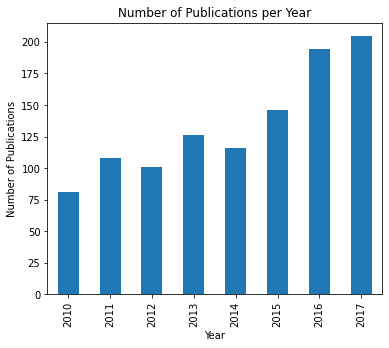

In [13]:
# Visualizing the number of publications per year
date_pub = df.groupby(transport_topics['Year'])['abstract'].count()
date_pub.plot(kind='bar', 
              title='Number of Publications per Year', 
              ylabel='Number of Publications',
              xlabel='Year', 
              figsize=(6, 5)
              )


# **Model Development**

## Removing symbols from the abstract and keywords

In [14]:
#Removing symbols from Abstracts

transport_topics['Abstract_Cleaned'] = transport_topics.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+"," ", str(row['abstract']))),axis=1)



To get the data ready to be consumed by LDA, we have to clean up the text more. In this, we shall tokenize each sentence into list of words. This will help us remove punctuations and uncessary characters altogether. To do this, we shall use *Gensim's simple_preprocess method* to run this. We shall also set this to true ie deacc=True

## Tokenization, Stopwords, Bigrams, Trigrams and Lemmatization

In [15]:
# Tokenization

transport_topics['Abstract_Cleaned']= transport_topics.apply(lambda row: (word_tokenize(str(row['Abstract_Cleaned']))), axis = 1)

In [16]:
# Running the Stopwords

stopwords = stopwords.words("english")
stop_words = set(stopwords)

In [17]:
transport_topics['Abstract_Cleaned'] = transport_topics.apply(lambda row: ([w for w in row['Abstract_Cleaned'] if w not in stop_words]),axis=1)

In [18]:
df2 = transport_topics['Abstract_Cleaned']

In [19]:
display(df2.head())

0    [This, paper, develops, time, dependent, frame...
1    [Understanding, affects, decision, process, le...
2    [This, paper, studies, intersection, signal, c...
3    [Static, path, optimization, SPO, foundation, ...
4    [In, paper, authors, present, robust, counterp...
Name: Abstract_Cleaned, dtype: object

In [20]:
# Lemmatization

lementize = WordNetLemmatizer()
df2 = transport_topics.apply(lambda row: ([lementize .lemmatize(w) for w in row['Abstract_Cleaned']]), axis=1)

We shall love to identify words that showed up together. To do this we shall be using the N-grams analyses. However, we shall be investigating only two or three words. This is called Bigrams and Trigrams respectively.

**NOTE: ** *An n-gram is a contiguous sequence of n items from a given sample of text or speech.*

Displaying the word count distribution

In [21]:
bigram = gensim.models.Phrases(df2,
                               min_count=5, #This defines the minimum time the words needs to occur to be considered as bigram
                               threshold=1000) # The higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[df2], threshold=100)


# Creating an object 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# defining the functions stopwords, bigrams and trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [30]:
# Removing of Stop Words
data_words_nostops = remove_stopwords(df2)

# Forming of trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Displaying The Topics

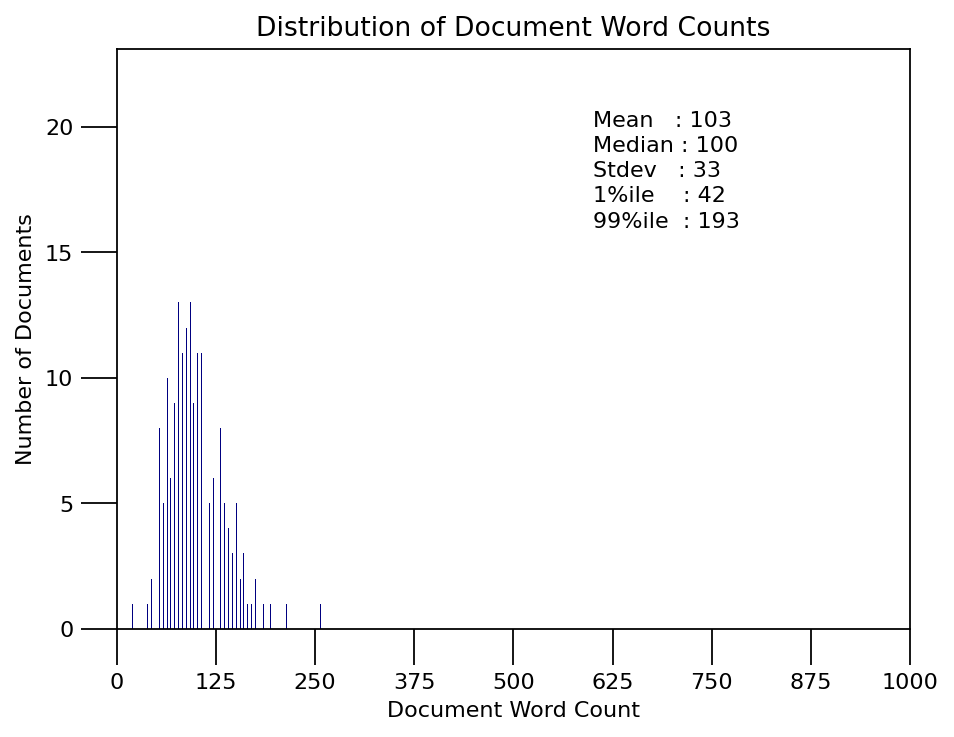

In [23]:
doc_lens = [len(distribution) for distribution in data_lemmatized]

# Plot
plt.figure(figsize=(6.4, 4.8), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(600, 20, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(600, 19, "Median : " + str(round(np.median(doc_lens))))
plt.text(600, 18, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(600, 17, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(600, 16, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))


plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts')
plt.show()

# **Creation of the Latent Dirichlet Allocation Model**

LDA stands for *Latent Dirichlet Allocation* This is a type of topic modeling algorithm. The purpose of LDA is to learn the representation of a fixed number of topics, and given this number of topics learn the topic distribution that each document in a collection of documents has

Before creating the LDA model, we need to create a dictionary that will contain our cleaned abstract. 

In [24]:
# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [dictionary.doc2bow(text) for text in data_lemmatized]

Building our LDA model using Gensim

In [25]:
# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=25, #Identifies the 25 topic trends for transportation
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

doc_lda = lda_model[corpus]

In [26]:
# Printing of the keywords in the topics

pprint(lda_model.show_topics(formatted=False))


[(13,
  [('source', 0.06512987),
   ('trade', 0.045173783),
   ('site', 0.040406674),
   ('mechanism', 0.0329754),
   ('panel', 0.031640574),
   ('reference', 0.02912658),
   ('hypothetical', 0.026253037),
   ('loss', 0.024065124),
   ('limitation', 0.019442359),
   ('psychological', 0.017859435)]),
 (11,
  [('stop', 0.09174625),
   ('charge', 0.053283878),
   ('station', 0.052258007),
   ('infrastructure', 0.031791538),
   ('wait', 0.026819773),
   ('action', 0.02056839),
   ('waiting', 0.020266762),
   ('line', 0.019517427),
   ('battery', 0.01874809),
   ('metaheuristic', 0.017555248)]),
 (7,
  [('parking', 0.072828494),
   ('signal', 0.061196424),
   ('lane', 0.056751538),
   ('cycle', 0.03909413),
   ('intersection', 0.033130523),
   ('delay', 0.020027665),
   ('traffic', 0.018675707),
   ('discharge', 0.014754855),
   ('control', 0.013961559),
   ('group', 0.013459547)]),
 (15,
  [('datum', 0.052678652),
   ('information', 0.051902752),
   ('segment', 0.046523623),
   ('measureme

# **Data Visualization of the Model**

Visulazation of the data to see the top 25 topics

##**WordCloud Visualization**

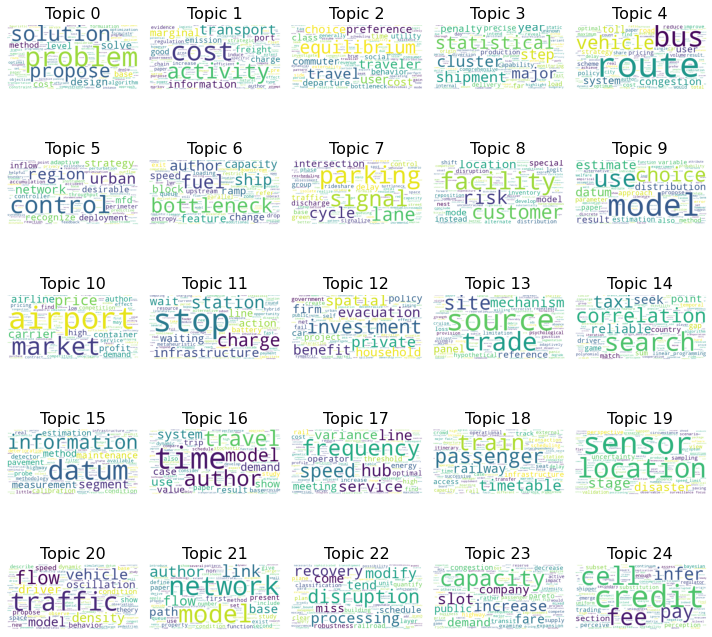

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors



cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  max_words=200,
                  prefer_horizontal=1)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    plt.imshow(cloud.fit_words(dict(lda_model.show_topic(i, 200))))
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##**PyDavis Visualization**

In [28]:
vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary, 
                                     mds="mmds", 
                                     R=20) #This choses the number of word a topic should contain.
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.230723  0.303540       1        1  18.239011
21     0.374865  0.165203       2        1  16.074550
9      0.167402  0.409865       3        1  11.478472
0     -0.007721  0.460482       4        1  10.198861
20     0.433612  0.030574       5        1   8.088284
4      0.336831  0.262029       6        1   6.574622
1      0.043142  0.275854       7        1   3.311774
2     -0.415731 -0.097972       8        1   2.864266
10    -0.356599  0.263674       9        1   2.243124
18     0.151554 -0.050592      10        1   1.782217
24     0.372803 -0.157481      11        1   1.730802
6     -0.166592  0.211868      12        1   1.650878
23    -0.443451  0.066530      13        1   1.638426
12    -0.235299  0.360573      14        1   1.513648
7      0.232721 -0.324175      15        1   1.435933
8     -0.286504  0.047901      16        1   1.429508
17    -0.013146  0.067288      17        1   1.365564
15    -0.194413 -0.096602      18        1   1.321208
14     0.122916 -0.412171      19        1   1.232435
5      0.305416 -0.246603      20        1   1.148630
22    -0.215087 -0.277697      21        1   1.116750
19    -0.009696 -0.369352      22        1   0.973847
11     0.005608 -0.184446      23        1   0.972121
3     -0.124467 -0.404443      24        1   0.967851
13    -0.308888 -0.303849      25        1   0.647220, topic_info=           Term         Freq        Total Category  logprob  loglift
275     problem  1067.000000  1067.000000  Default  20.0000  20.0000
178     traffic  1039.000000  1039.000000  Default  19.0000  19.0000
222     network  1108.000000  1108.000000  Default  18.0000  18.0000
66         time  1587.000000  1587.000000  Default  17.0000  17.0000
41        model  2467.000000  2467.000000  Default  16.0000  16.0000
...         ...          ...          ...      ...      ...      ...
4212    shelter     5.833453     6.759272  Topic25  -4.8145   4.8929
556    matching     5.358483     6.284302  Topic25  -4.8994   4.8809
2164      never     5.348048     6.273866  Topic25  -4.9014   4.8806
1079       loss    17.307262    22.586536  Topic25  -3.7270   4.7740
943   mechanism    23.715395    63.522200  Topic25  -3.4120   4.0550

[858 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3270     22  0.718462      absence
3270     25  0.221065      absence
1859     10  0.989634       access
3634     20  0.951668     accident
1325      6  0.947932  accommodate
...     ...       ...          ...
180      24  0.024484         work
2326     21  0.951538         yard
2306     11  0.136278         year
2306     24  0.851738         year
903      12  0.977436         zone

[1450 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 22, 10, 1, 21, 5, 2, 3, 11, 19, 25, 7, 24, 13, 8, 9, 18, 16, 15, 6, 23, 20, 12, 4, 14])

# **Computation of  Model Perplexity and Coherence Score**

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=corpora.Dictionary(data_lemmatized), coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.140817862422805

Coherence Score:  0.40202323978929505
